# HUK Data project

The goal of this project is to predict the claim amount per year given some characteristics of the customer.

The project is organized as follows:
1. Data loading and data wrangling
2. Explorative data analysis
3. Feature engineering
4. Model selection
5. Training of the selected model
6. Conclusions and improvements

## Data Loading and Data Wrangling

Importing required packages:

In [1]:
import pandas as pd
import arff
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/tmp/ipykernel_4461/539414081.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Import data and convert to pandas data frame:

In [2]:
data_freq = arff.load(open('freMTPL2freq.arff','r'))
df_freq = pd.DataFrame(data_freq['data'], columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower",
                                                   "VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
data_sev = arff.load(open('freMTPL2sev.arff','r'))
df_sev = pd.DataFrame(data_sev['data'], columns=["IDpol", "ClaimAmount"])

# shape of data frames
print('shape of df_freq:', df_freq.shape)
print('shape of df_sev:', df_sev.shape)


shape of df_freq: (678013, 12)
shape of df_sev: (26639, 2)


In [3]:
df_freq.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
1,3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
2,5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
3,10.0,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
4,11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72


In [4]:
df_sev.head()

,IDpol,ClaimAmount
0,1552.0,995.20
1,1010996.0,1128.12
2,4024277.0,1851.11
3,4007252.0,1204.00
4,4046424.0,1204.00


Check for data types and missing values: there are no missing values in both data frames. For some columns the data type could be changed from float64 to int (e.g. `IDpol`, `ClaimNb`,...).

In [5]:
print(df_freq.info())
print(df_freq.isnull().sum())

print(df_sev.info())
print(df_sev.isnull().sum())

# To do: maybe change data type of certain columns to save memory

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  float64
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  float64
 5   VehAge      678013 non-null  float64
 6   DrivAge     678013 non-null  float64
 7   BonusMalus  678013 non-null  float64
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  float64
 11  Region      678013 non-null  object 
dtypes: float64(8), object(4)
memory usage: 62.1+ MB
None
IDpol         0
ClaimNb       0
Exposure      0
Area          0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Density       0
Region        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>


Combine both data frames to a new data frame `df`:

In [6]:
# sum up claims of each individual customer in df_sev
# after this operation the index is given by IDpol
df_sev = df_sev.groupby('IDpol').sum()

# Change index to IDpol in df_freq
df_freq.set_index('IDpol',inplace=True)

# Combine both data frames in a new data frame df making sure that the indices are used correctly
df = pd.concat([df_freq,df_sev],axis=1,join='outer')

# Set the claim amount of contracts with ClaimNb==0 to zero (no claims were made)
df.loc[df['ClaimNb']==0,'ClaimAmount'] = 0

df.head()

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,NaN
3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,NaN
5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,NaN
10.0,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,NaN
11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,NaN


We need to check if there are missing values in the new data frame `df`: there are 6 rows with missing values in columns `ClaimNb` - `Region` (induced by contracts in `df_sev` that are not present in `df_freq`) and 9116 rows with missing values in the column `ClaimAmount` (fore some contracts in `df_freq` there is no information on `ClaimAmount` available).

We drop these rows. The new shape of the data frame is (668897, 12).

In [7]:
print(df.info())
print(df.isnull().sum())

df.dropna(inplace=True)
print('\nNew shape of data frame', df.shape)

<class 'pandas.core.frame.DataFrame'>
Index: 678019 entries, 1.0 to 2286775.0
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ClaimNb      678013 non-null  float64
 1   Exposure     678013 non-null  float64
 2   Area         678013 non-null  object 
 3   VehPower     678013 non-null  float64
 4   VehAge       678013 non-null  float64
 5   DrivAge      678013 non-null  float64
 6   BonusMalus   678013 non-null  float64
 7   VehBrand     678013 non-null  object 
 8   VehGas       678013 non-null  object 
 9   Density      678013 non-null  float64
 10  Region       678013 non-null  object 
 11  ClaimAmount  668903 non-null  float64
dtypes: float64(8), object(4)
memory usage: 67.2+ MB
None
ClaimNb           6
Exposure          6
Area              6
VehPower          6
VehAge            6
DrivAge           6
BonusMalus        6
VehBrand          6
VehGas            6
Density           6
Region            6
ClaimAmou

Let's define the target variable/dependent variable that we denote by `target`:

In [8]:
df['target'] = df['ClaimAmount'] / df['Exposure']

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,target
IDpol,,,,,,,,,,,,,
139.0,1.0,0.75,F,7.0,1.0,61.0,50.0,B12,Regular,27000.0,R11,303.00,404.000000
190.0,1.0,0.14,B,12.0,5.0,50.0,60.0,B12,Diesel,56.0,R25,1981.84,14156.000000
414.0,1.0,0.14,E,4.0,0.0,36.0,85.0,B12,Regular,4792.0,R11,1456.55,10403.928571
424.0,2.0,0.62,F,10.0,0.0,51.0,100.0,B12,Regular,27000.0,R11,10834.00,17474.193548
463.0,1.0,0.31,A,5.0,0.0,45.0,50.0,B12,Regular,12.0,R73,3986.67,12860.225806


## Explorative Data Analysis

First, we consider the numerical data: there are contract with very high claim amount and claim number.

In [9]:
df.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,target
count,668897.000000,668897.000000,668897.000000,668897.000000,668897.000000,668897.000000,668897.000000,6.688970e+05,6.688970e+05
mean,0.039535,0.529071,6.456946,7.084602,45.447846,59.784367,1790.705328,8.956419e+01,3.884840e+02
std,0.208533,0.364249,2.052244,5.663181,14.119466,15.641503,3949.352296,5.861986e+03,3.707073e+04
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00,0.000000e+00
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000e+00,0.000000e+00
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00,0.000000e+00
75%,0.000000,0.990000,7.000000,11.000000,55.000000,65.000000,1658.000000,0.000000e+00,0.000000e+00
max,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000,4.075401e+06,1.852455e+07


Now, consider the columns with data type 'object':

In [11]:
df.describe(include=['object'])

,Area,VehBrand,VehGas,Region
count,668897,668897,668897,668897
unique,6,11,2,22
top,C,B12,Regular,R24
freq,189254,161594,339770,158055


Check for outliers with too many claims: there are only 8 contract with more than 4 claims and total claim amount of roughly 1.4 million. Later, we drop those contracts because there are not important for predicting the individual claim amount (but of course those contract should be taken into account for the pricing of contracts).

In [24]:
print(df['ClaimNb'].value_counts())
print(df.loc[df['ClaimNb']>4,['ClaimNb','target']])
print('\nContract with more than 4 claims:', (df['ClaimNb']>4).sum())
print('Total claims of these contracts:', df.loc[df['ClaimNb']>4,['target']].sum())

ClaimNb
0.0     643953
1.0      23570
2.0       1299
3.0         62
4.0          5
5.0          2
11.0         2
6.0          1
8.0          1
16.0         1
9.0          1
Name: count, dtype: int64
           ClaimNb         target
IDpol                            
93954.0        5.0    6918.100000
2216294.0      6.0   29253.333333
2239279.0      8.0   60550.658537
2241683.0     16.0  107664.757576
2248174.0      9.0  229433.250000
2277762.0      5.0  358400.000000
3253234.0     11.0  321055.250000
3254353.0     11.0  251254.000000

Contract with more than 4 claims: 8
Total claims of these contracts: target    1.364529e+06
dtype: float64


Check for outliers in the `ClaimAmount` column: Drop the 4 highest ClaimAmounts. These probably correspond to catastrophic events and are not important for the individual claim amount per year (but should be considered in the pricing).

In [31]:
df.nlargest(10,'ClaimAmount')

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,target
IDpol,,,,,,,,,,,,,
1120377.0,1.0,0.22,B,9.0,13.0,19.0,100.0,B2,Regular,93.0,R24,4075400.56,1.852455e+07
110846.0,2.0,0.43,C,6.0,13.0,20.0,100.0,B1,Regular,203.0,R24,1404185.52,3.265548e+06
2141337.0,1.0,0.32,D,4.0,14.0,18.0,100.0,B2,Regular,863.0,R82,1301172.60,4.066164e+06
3122016.0,1.0,0.91,E,7.0,7.0,40.0,63.0,B11,Diesel,9307.0,R82,774411.50,8.510016e+05
2008127.0,3.0,0.36,D,4.0,2.0,57.0,50.0,B4,Regular,1217.0,R82,399213.66,1.108927e+06
3025890.0,2.0,0.09,A,7.0,1.0,36.0,50.0,B12,Diesel,38.0,R21,382955.14,4.255057e+06
1117644.0,1.0,0.85,C,7.0,1.0,21.0,90.0,B3,Diesel,108.0,R53,307096.42,3.612899e+05
158309.0,1.0,0.75,A,6.0,3.0,46.0,50.0,B1,Diesel,10.0,R24,301635.49,4.021807e+05
3075820.0,1.0,0.58,E,7.0,18.0,78.0,50.0,B10,Regular,4762.0,R93,287423.00,4.955569e+05


Check the range of the different independent variables

In [15]:
print(f"Number of entries in Area: {df.value_counts('Area').index.shape[0]}, Entries: {df.value_counts('Area').index.tolist()}")
print(f"Number of entries in VehPower: {df.value_counts('VehPower').index.shape[0]}, Entries: {df.value_counts('VehPower').index.tolist()}")
print(f"Number of entries in VehAge: {df.value_counts('VehAge').index.shape[0]}, Entries: {df.value_counts('VehAge').index.tolist()}")
print(f"Number of entries in VehBrand: {df.value_counts('VehBrand').index.shape[0]}, Entries: {df.value_counts('VehBrand').index.tolist()}")
print(f"Number of entries in VehGas: {df.value_counts('VehGas').index.shape[0]}, Entries: {df.value_counts('VehGas').index.tolist()}")
print(f"Number of entries in Region: {df.value_counts('Region').index.shape[0]}, Entries: {df.value_counts('Region').index.tolist()}")

Number of entries in Area: 6, Entries: ['C', 'D', 'E', 'A', 'B', 'F']
Number of entries in VehPower: 12, Entries: [6.0, 7.0, 5.0, 4.0, 8.0, 10.0, 9.0, 11.0, 12.0, 13.0, 15.0, 14.0]
Number of entries in VehAge: 78, Entries: [1.0, 2.0, 0.0, 3.0, 4.0, 5.0, 10.0, 6.0, 7.0, 8.0, 9.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 29.0, 28.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 100.0, 99.0, 46.0, 48.0, 40.0, 44.0, 43.0, 47.0, 49.0, 45.0, 42.0, 50.0, 41.0, 52.0, 51.0, 69.0, 81.0, 80.0, 70.0, 66.0, 83.0, 68.0, 65.0, 59.0, 54.0, 53.0, 64.0, 62.0, 60.0, 71.0, 76.0, 78.0, 79.0, 55.0, 82.0, 84.0, 85.0, 63.0]
Number of entries in VehBrand: 11, Entries: ['B12', 'B1', 'B2', 'B3', 'B5', 'B6', 'B4', 'B10', 'B11', 'B13', 'B14']
Number of entries in VehGas: 2, Entries: ['Regular', 'Diesel']
Number of entries in Region: 22, Entries: ['R24', 'R82', 'R93', 'R11', 'R53', 'R52', 'R91', 'R72', 'R31', 'R54', 'R73', 'R41', 'R25', 'R26

Check the correlation of all variables: BonusMalus and DrivAge are weakly negatively correlated. The rest of the variables do not seem to be correlated.

In [48]:
df_num = df.select_dtypes(include=['number'])
df_num.corr()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,target
ClaimNb,1.000000,0.084697,0.000695,0.009047,-0.004394,0.066032,0.010781,0.083528,0.056594
Exposure,0.084697,1.000000,-0.045085,0.147937,0.170162,-0.182421,-0.069744,0.002247,-0.008589
VehPower,0.000695,-0.045085,1.000000,-0.007127,0.031284,-0.076180,0.043197,0.001265,0.000173
VehAge,0.009047,0.147937,-0.007127,1.000000,-0.060356,0.081397,-0.089524,0.002229,0.001349
DrivAge,-0.004394,0.170162,0.031284,-0.060356,1.000000,-0.479632,-0.003515,-0.003637,-0.005848
BonusMalus,0.066032,-0.182421,-0.076180,0.081397,-0.479632,1.000000,0.077006,0.009998,0.008972
Density,0.010781,-0.069744,0.043197,-0.089524,-0.003515,0.077006,1.000000,-0.000050,-0.000138
ClaimAmount,0.083528,0.002247,0.001265,0.002229,-0.003637,0.009998,-0.000050,1.000000,0.684834
target,0.056594,-0.008589,0.000173,0.001349,-0.005848,0.008972,-0.000138,0.684834,1.000000


### Graphics

First, we consider impact of the drivers' age on the claim amount: it seems that drivers younger than 25 have in average a higher claim amount, between 25-65 it appears to be "constant", and above an age of 65 the claim amounts seem to increase. Most drivers are 30-55 years old.

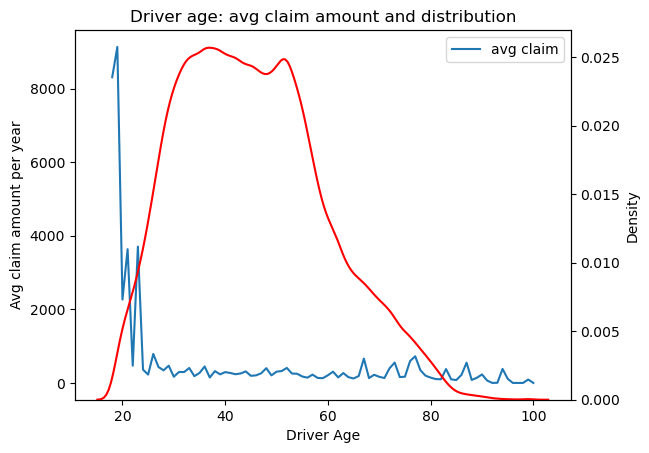

In [25]:
# To do: Use plotly for nicer graphics

fig, ax0 = plt.subplots() 

mean_age = df.groupby('DrivAge')['target'].mean().reset_index()
sns.lineplot(x='DrivAge',y='target', data=mean_age, ax=ax0,label='avg claim')
ax0.set_title('Driver age: avg claim amount and distribution')
ax0.set_xlabel('Driver Age')
ax0.set_ylabel('Avg claim amount per year')

ax1 = ax0.twinx()
sns.kdeplot(df['DrivAge'], ax=ax1,color='r',label='distribution') 

ax0.legend()
plt.show()

Now, vehicle power: most vehicle have power $\le 7$. Especially, vehicles with power equal to 9 have a high average claim.

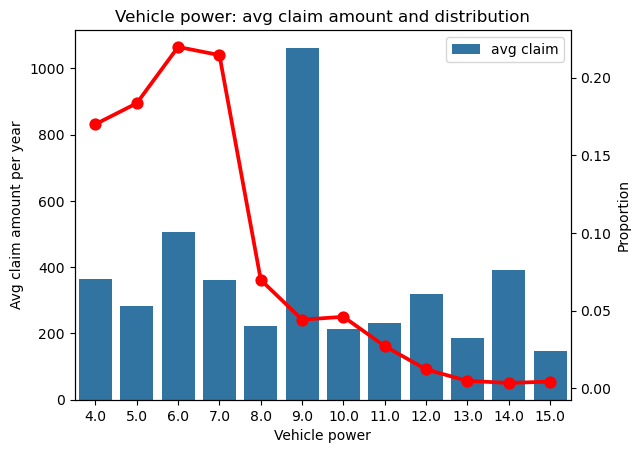

In [24]:
fig, ax0 = plt.subplots()

sns.barplot(x='VehPower', y='target',data=df, ax=ax0,errorbar=None, label='avg claim') 
ax0.set_title('Vehicle power: avg claim amount and distribution')
ax0.set_xlabel('Vehicle power')
ax0.set_ylabel('Avg claim amount per year')

ax1 = ax0.twinx()
power_df = pd.DataFrame(df['VehPower'].value_counts().sort_index()/df.shape[0])
sns.pointplot(power_df['count'], ax=ax1, color='r') # add to subplot 2
ax1.set_ylabel('Proportion')

ax0.legend()
plt.show()

Area: Area B and E have high avg claim. The avg claims of areas A, C, F are comparable. Area F represents a small proportion of drivers, while areas C, D, E represent the majority.

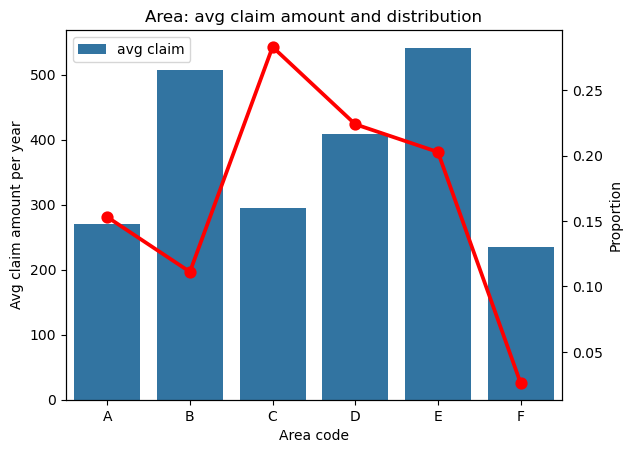

In [23]:
fig, ax0 = plt.subplots()

sns.barplot(x='Area', y='target', data=df, order=['A','B','C','D','E','F'], ax=ax0,errorbar=None,label='avg claim') 
ax0.set_title('Area: avg claim amount and distribution')
ax0.set_xlabel('Area code')
ax0.set_ylabel('Avg claim amount per year')

ax1 = ax0.twinx()
area_df = df['Area'].value_counts().sort_index()/df.shape[0]
sns.pointplot(area_df, ax=ax1, color='r') 
ax1.set_ylabel('Proportion')

ax0.legend()
plt.show()

Region: region R21 only represents a small proportion of drivers but with very high avg claims. Region R24 represent alomst 25% of all drivers with avg claim $\approx 450$. Regions R11, R93, R82, R24 represents the majority of drivers.

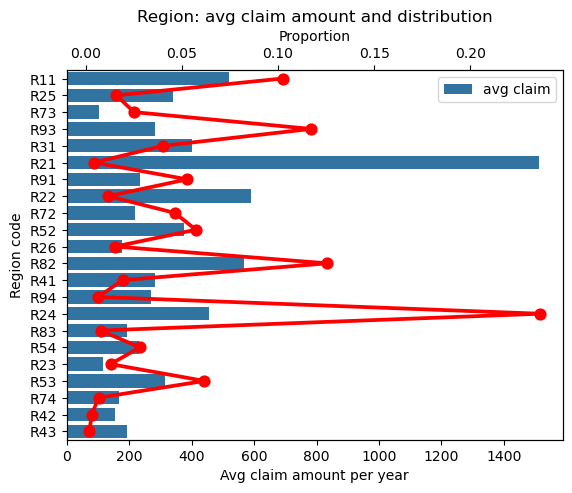

In [22]:
fig, ax0 = plt.subplots()

sns.barplot(y='Region', x='target', data=df, ax=ax0, orient='h',errorbar=None,label='avg claim') 
ax0.set_title('Region: avg claim amount and distribution')
ax0.set_ylabel('Region code')
ax0.set_xlabel('Avg claim amount per year')

ax1 = ax0.twiny()
region_df = df['Region'].value_counts().sort_index()/df.shape[0]
sns.pointplot(region_df, ax=ax1, color='r',orient='h') 
ax1.set_xlabel('Proportion')

ax0.legend()
plt.show()

Density: most drivers live in an area with low density.

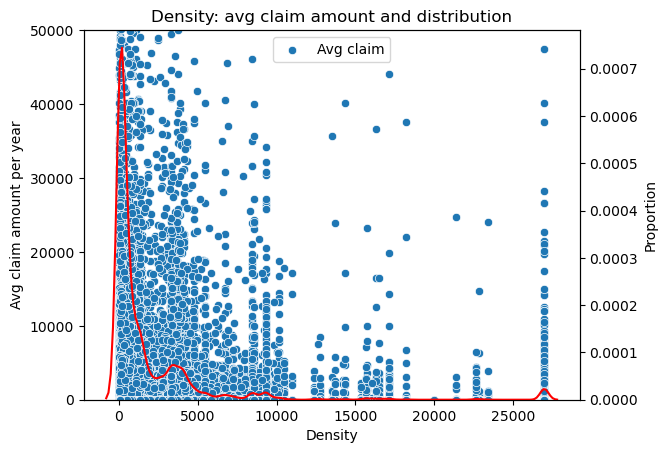

In [75]:
fig, ax0 = plt.subplots()

sns.scatterplot(x='Density', y='target', data=df, label='Avg claim')
ax0.set_title('Density: avg claim amount and distribution')
ax0.set_xlabel('Density')
ax0.set_ylabel('Avg claim amount per year')
ax0.set_ylim(0,50000)

ax1 = ax0.twinx()
sns.kdeplot(df['Density'], ax=ax1, color='r', legend='Proportion') 
ax1.set_ylabel('Proportion')

ax0.legend()
plt.show()

Vehicle brand: almost 75% of drive have a car from brand B1, B2, B12. Brand B2 has the highest avg claims.

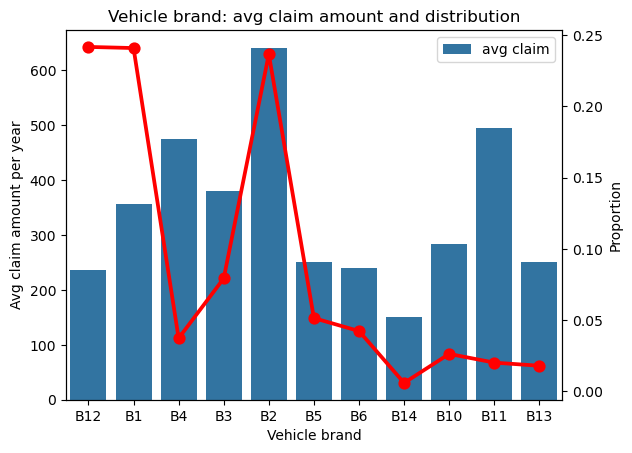

In [21]:
fig, ax0 = plt.subplots() 

sns.barplot(x='VehBrand', y='target', data=df, ax=ax0,errorbar=None,label='avg claim') 
ax0.set_title('Vehicle brand: avg claim amount and distribution')
ax0.set_xlabel('Vehicle brand')
ax0.set_ylabel('Avg claim amount per year')

ax1 = ax0.twinx()
brand_df = df['VehBrand'].value_counts().sort_index()/df.shape[0]
sns.pointplot(brand_df, ax=ax1, color='r', label='Proportion') 
ax1.set_ylabel('Proportion')

ax0.legend()
plt.show()

Vehicle age: most cars are younger than 10 years. The percentage of cars older than 20 years is very low.

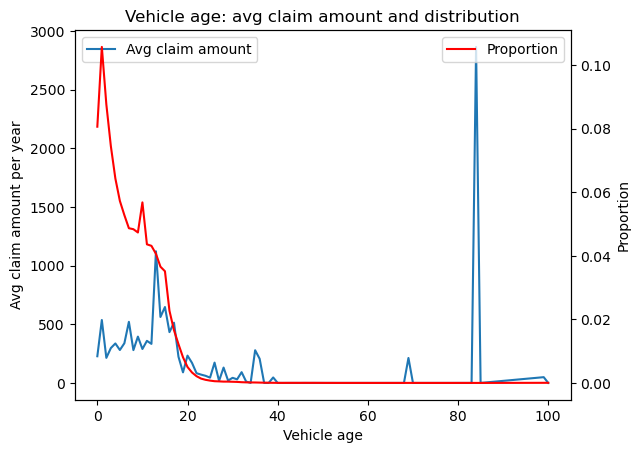

In [42]:
fig, ax0 = plt.subplots()

mean_target_vehage = df.groupby('VehAge')['target'].mean().reset_index()
sns.lineplot(x='VehAge',y='target', data=mean_target_vehage, ax=ax0, label='Avg claim amount')
ax0.set_title('Vehicle age: avg claim amount and distribution')
ax0.set_xlabel('Vehicle age')
ax0.set_ylabel('Avg claim amount per year')

ax1 = ax0.twinx()
brand_df = df['VehAge'].value_counts().sort_index()/df.shape[0]
sns.lineplot(brand_df, ax=ax1, color='r', label='Proportion') 
ax1.set_ylabel('Proportion')

ax0.legend()
plt.show()

Bonus malus: most drivers have bonus malus below 100 with almost 20% being around 50 (which is the minimal value). Average claims are higher if bonus malus is above 100. The regression plot below indicates that bonus malus and claim amount per year might depend in a monotonically increasing way.

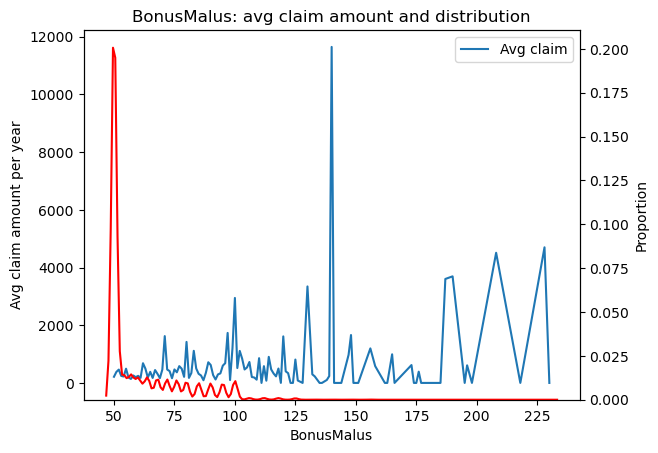

In [19]:
fig, ax0 = plt.subplots()

mean_bonus = df.groupby('BonusMalus')['target'].mean().reset_index()
sns.lineplot(x='BonusMalus', y='target', data=mean_bonus, label='Avg claim')
ax0.set_title('BonusMalus: avg claim amount and distribution')
ax0.set_xlabel('BonusMalus')
ax0.set_ylabel('Avg claim amount per year')

ax1 = ax0.twinx()
sns.kdeplot(df['BonusMalus'], ax=ax1, color='r', legend='Proportion') 
ax1.set_ylabel('Proportion')

ax0.legend()
plt.show()

(0.0, 15000.0)

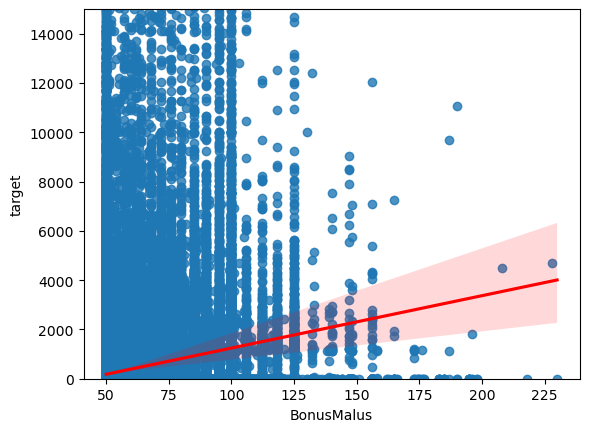

In [44]:
sns.regplot(x='BonusMalus', y='target',data=df, line_kws=dict(color="r"))
plt.tile('Regression plot BonusMalus vs target')
plt.ylim(0,15000)
plt.show()

Vehicle gas: the number of cars with diesel and petrol (?) is almost identical. Cars with regular gas have higher avg claim amount per year.

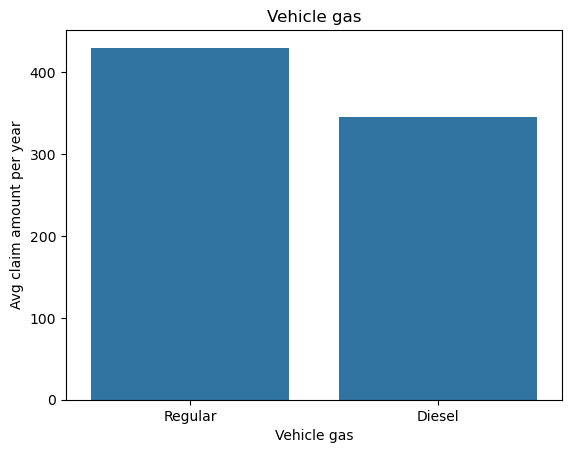

VehGas
Regular    339770
Diesel     329127
Name: count, dtype: int64


In [20]:
fig, ax0 = plt.subplots() 
sns.barplot(x='VehGas', y='target', data=df, ax=ax0, errorbar=None) 
ax0.set_title('Vehicle gas')
ax0.set_xlabel('Vehicle gas')
ax0.set_ylabel('Avg claim amount per year')
plt.show()

print(df['VehGas'].value_counts())

## Feature Engineering

First, we drop rows in the data frame that are outliers.

In [9]:
# drop rows with too high claim amount and too many claims
df = df[(df['ClaimNb']<=4) & (df['ClaimAmount']<700000)]

# drop column used to construct the target column
df.drop(['ClaimNb','Exposure','ClaimAmount'],axis=1,inplace=True)

df_full = df.copy() # make copy before binning

We bin some columns to reduce the number of independent variables. Binning for the columns: DrivAge, VehAge, Region, VehBrand

Bin VehBrand according the average claim amount, i.e. according to the dictionary {'B1': 3,'B10': 2, 'B11': 4, 'B12': 2, 'B13': 2, 'B14': 1, 'B2': 5, 'B3': 3, 'B4': 4, 'B5': 2, 'B6': 2}. This binning could be made more precise.

In [10]:
# VehBrand binning

#average claim amount for brands
avg_target_VehBrand = df[['VehBrand','target']].groupby(['VehBrand'],as_index=False).mean()

bin = [0,200,300,400,600,1000]
names = [1,2,3,4,5]

avg_target_VehBrand['VehBrand_binned'] = pd.cut(avg_target_VehBrand['target'], bin, labels=names,include_lowest=True)
avg_target_VehBrand.set_index('VehBrand',inplace=True)
avg_target_VehBrand.drop('target',inplace=True,axis=1)
dict = avg_target_VehBrand.transpose().to_dict(orient='list')

for key, value in dict.items():
    dict[key] = value[0]

df['VehBrand-bin'] = df['VehBrand'].map(dict)
df['VehBrand-bin'] = df['VehBrand-bin'].astype('category')



Bin `Region` according the average claim amount, i.e. according to the dictionary {'R11': 5, 'R21': 6, 'R22': 5, 'R23': 1, 'R24': 4, 'R25': 3, 'R26': 2, 'R31': 4, 'R41': 3, 'R42': 2, 'R43': 2, 'R52': 4, 'R53': 3, 'R54': 2, 'R72': 2, 'R73': 1, 'R74': 2, R82': 5, 'R83': 2, 'R91': 2, 'R93': 3, 'R94': 3}.

In [11]:
# Region binning
avg_target_Region = df[['Region','target']].groupby(['Region'],as_index=False).mean()

bin = list(np.linspace(0,600,6))
bin.append(max(avg_target_Region['target']))
names = [1,2,3,4,5,6]
avg_target_Region['Region_binned'] = pd.cut(avg_target_Region['target'], bin, labels=names,include_lowest=True)

avg_target_Region.set_index('Region',inplace=True)
avg_target_Region.drop('target',inplace=True,axis=1)
dict = avg_target_Region.transpose().to_dict(orient='list')

for key, value in dict.items():
    dict[key] = value[0]

df['Region-bin'] = df['Region'].map(dict)
df['Region-bin'] = df['Region-bin'].astype('category')


Bin `VehAge` according to 0-1: 1, 2-3: 2, 4-5: 3, 6-10: 4, 11-15: 5, 16-20: 6, >20: 7.

In [12]:
#VehAge binning
bin = [0,2,4,6,10,16,20,max(df['VehAge'])]
names = [1,2,3,4,5,6,7]
df['VehAge-bin'] = pd.cut(df['VehAge'], bin, labels=names,include_lowest=True)

Bin `DrivAge` according to the list `bin`:

In [13]:
#DrivAge binning
bin = [0,23,30,40,50,60,70,80,max(df['DrivAge'])]
names = [1,2,3,4,5,6,7,8]
df['DrivAge-bin'] = pd.cut(df['DrivAge'], bin, labels=names,include_lowest=True)

Drop all columns that are binned and convert categorical data into dummy variables (one hot encoding):

In [14]:
df.drop(['VehAge','VehBrand','Region','DrivAge'],inplace=True,axis=1)
columns_cate = ['Area','VehGas','Region-bin','VehBrand-bin','VehAge-bin','DrivAge-bin']
dummy_variables = pd.get_dummies(df[columns_cate]) # get dummy variables
df= pd.concat([df,dummy_variables], axis=1) # define new data frame
df.drop(columns_cate, inplace=True, axis=1) # drop columns with categorical data

In [15]:
# the same for df_full
columns_cate = ['Area','VehGas','Region','VehBrand']
dummy_variables = pd.get_dummies(df_full[columns_cate]) # get dummy variables
df_full= pd.concat([df_full,dummy_variables], axis=1) # define new data frame
df_full.drop(columns_cate, inplace=True, axis=1) # drop columns with categorical data

## Model selection

The following models are tested: Linear regression, Polynomial regression, regression trees and deep neural networks.

In [16]:
# import libraries
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

from tqdm import tqdm

We want to compare the models using k-fold cross validation. We choose 10 folds and calculate the average MSE and $R²$ score for each model to assess its quality.

In [76]:
# initialize a cross validation object
kf = KFold(n_splits=10) # shuffle=True

### Linear and polynomial regression

We consider a linear and polynomial regression model with all independent variables. In more detail, we consider a linear regression model with binned and original data, and a polynomial regression model of degree 2. Models with less independent variables should also be considered but we refrain from testing them because of time reasons.

The results show that all three tested model have a similar performance because both MSE and $R²$ score are almost identical.

In [81]:
# Prepare the data
columns_drop = ['target'] 
x = df.drop(columns=columns_drop,axis=1).astype(float).values 
y = df['target'].to_numpy().reshape(-1,1)

# We scale the data to make the MSE comparable to the MSE of a neural network
scaler_data = StandardScaler() # MinMaxScaler()
scaler_target = StandardScaler() # MinMaxScaler()
x = scaler_data.fit_transform(x)
y = scaler_target.fit_transform(y)

Try linear model with all independent variables and binned data (takes ~ 10 sec with cross validation):

In [82]:
mse_scores = []
r2scores = []

for train_index, val_index in tqdm(kf.split(x)):
    # Split data into training and validation sets
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Initialize and train a linear regression model
    model = LinearRegression()
    model.fit(x_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(x_val)

    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    mse_scores.append(mse)
    r2scores.append(r2)


avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2scores)


print('\nAvg MSE:', avg_mse)
print('Avg R2 score:', avg_r2)

10it [00:10,  1.08s/it]


Avg MSE: 0.9999330831583568
Avg R2 score: -0.0011665231391809084


Try polynomial regression with degree 2 and binned data (takes ~ 6 min with cross validation). Note: polynominals of degree larger than 2 are not feasible (if all independent varibales are used) because of storage problems.

In [24]:
mse_scores = []
r2scores = []

for train_index, val_index in tqdm(kf.split(x)):
    # Split data into training and validation sets
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Initialize and train a polynomial regression model
    Input = [('polynomial',PolynomialFeatures(degree=2)),('model',LinearRegression())]
    pipe = Pipeline(Input)
    pipe.fit(x_train,y_train)

    # Make predictions on the validation set
    y_pred = pipe.predict(x_val)

    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    mse_scores.append(mse)
    r2scores.append(r2)

10it [05:59, 36.00s/it]


In [27]:
avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2scores)

print('\nAvg MSE:', avg_mse)
print('Avg R2 score:', avg_r2)


Avg MSE: 1.0006937915820486
Avg R2 score: -0.012614858650656813


Try polynomial regression with degree 1 and no bins (takes ~ 16 sec with cross validation). Higher degrees are not feasible because of memory issues.

In [63]:
# use the original unbinned data
x = df_full.drop(columns=['target'],axis=1).astype(float).values
y = df_full['target'].to_numpy().reshape(-1,1)

# scale the data to make results comparable
scaler_data = StandardScaler() # MinMaxScaler()
scaler_target = StandardScaler() # MinMaxScaler()
x = scaler_data.fit_transform(x)
y = scaler_target.fit_transform(y)

mse_scores = []
r2scores = []

for train_index, val_index in tqdm(kf.split(x)):
    # Split data into training and validation sets
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Initialize and train a linear regression model
    model = LinearRegression()
    model.fit(x_train, y_train)

    # Make predictions on the validation set
    y_pred = model.predict(x_val)

    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    mse_scores.append(mse)
    r2scores.append(r2)


avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2scores)


print('\nAvg MSE:', avg_mse)
print('Avg R2 score:', avg_r2)

10it [00:15,  1.57s/it]


Avg MSE: 0.9999997784872544
Avg R2 score: -0.00030877294796841646


### Regression trees

Cross validation takes around 1 min. The MSE and $R²$ score are worse than the linear regression model. Hence, we do not train this model further.


In [85]:
# we take again the unbinned data
x = df_full.drop(columns=['target'],axis=1).astype(float).values
y = df_full['target'].to_numpy().reshape(-1,1)

# scale the data
scaler_data = StandardScaler() # MinMaxScaler()
scaler_target = StandardScaler() # MinMaxScaler()
x = scaler_data.fit_transform(x)
y = scaler_target.fit_transform(y)

mse_scores = []
r2scores = []

for train_index, val_index in tqdm(kf.split(x)):
    # Split data into training and validation sets
    x_train, x_val = x[train_index], x[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Initialize and train a linear regression model
    regressor = DecisionTreeRegressor() # max_depth=10
    regressor.fit(x_train, y_train)
    # Make predictions on the validation set
    y_pred = regressor.predict(x_val)

    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    mse_scores.append(mse)
    r2scores.append(r2)

avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2scores)

print('\nAvg MSE:', avg_mse)
print('Avg R2 score:', avg_r2)

10it [01:07,  6.72s/it]


Avg MSE: 2.247007138627456
Avg R2 score: -6.021352519464118


### Deep Neural Networks

Now, consider a deep neural network. We use two hidden layers (each with 20 nodes) and tanh activation. Then, we train the model with the SGD optimizer and MSE loss. The model performs worse than the linear regression model above.


First, import required packages:

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm import tqdm

Preprocess the data, i.e. scale and split the data into training and test samples.

In [79]:
x_data = df_full.drop(columns=['target'],axis=1).astype(float).values
y_target = df_full['target'].to_numpy().reshape(-1,1)

# scale the data for better training performance of the network
scaler_data = StandardScaler() # MinMaxScaler()
scaler_target = StandardScaler() # MinMaxScaler()
x_data = torch.tensor(scaler_data.fit_transform(x_data)).to(torch.float32)
y_target = torch.tensor(scaler_target.fit_transform(y_target)).to(torch.float32)

Define the neural network: use two hidden layers (each with 20 nodes) and tanh activation.

In [80]:
class Net(nn.Module):
    def __init__(self,D_in,H1,H2,D_out):
        super(Net,self).__init__()
        self.linear1=nn.Linear(D_in,H1)
        self.linear2=nn.Linear(H1,H2)
        self.linear3=nn.Linear(H2,D_out)

    def forward(self,x):
        x=torch.tanh(self.linear1(x))  
        x=torch.tanh(self.linear2(x))
        x=torch.tanh(self.linear3(x))
        return x

Train the NN for 20 epochs (~ 20 min with cross validation):

In [42]:
mse_scores = []
r2scores = []
dim_in = x_data.shape[1]

for train_index, val_index in tqdm(kf.split(x_data)):
    # Split data into training and validation sets
    x_train, x_val = x_data[train_index], x_data[val_index]
    y_train, y_val = y_target[train_index], y_target[val_index]
    x_train = x_train.clone().detach().to(torch.float32)
    y_train = y_train.clone().detach().to(torch.float32)
    x_val = x_val.clone().detach().to(torch.float32)
    y_val = y_val.clone().detach().to(torch.float32)
    dataset = TensorDataset(x_train, y_train)

    # Initialize and train NN
    torch.manual_seed(0)
    model = Net(D_in=dim_in,H1=20,H2=20,D_out=1)
    learning_rate = 0.1
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    train_loader = DataLoader(dataset,batch_size=100)

    epochs = 20
    cost = []

    for epoch in tqdm(range(epochs)):
        total=0
        
        for x,y in train_loader:

            optimizer.zero_grad()    
            yhat=model(x)
            loss=criterion(yhat,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total+=loss.item()

        cost.append(total)

    # Make predictions on the validation set
    y_pred = model(x_val)

    mse = mean_squared_error(y_val.detach().numpy(), y_pred.detach().numpy())
    r2 = r2_score(y_val.detach().numpy(), y_pred.detach().numpy())
    
    mse_scores.append(mse)
    r2scores.append(r2)

avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2scores)

print('\nAvg MSE:', avg_mse)
print('Avg R2 score:', avg_r2)

100%|██████████| 20/20 [02:08<00:00,  6.44s/it]
10it [19:55, 119.55s/it]


Avg MSE: 1.7230012
Avg R2 score: -4.60501929708514


### Conclusions

- The $R²$ scores of all models are less or equal to zero. This indicates a bad fit of the model to the data. Hence, we should actually consider another model that fits the data better, e.g. a generalized linear model (see the "Improvement" section below). For time reason, we cannot follow this approach.

- The MSE and R2 score of the linear regression and polynomial regression is almost identical (roughly equal to 1 and 0, respectively). The regression tree model and neural network yields a worse MSE and R2 score. In the linear regression model, it makes almost no difference in the metrics if we bin certain independent variables (except of saving memory).

- Of course, the neural network could be further optimized by adapting its architecture (i.e., nb of hidden layers, nb of nodes, activation functions) and training procedure (change lerning rate, nb of epochs and batch sizes and use, e.g., batch normalization, dropout, initialization and the optimization algorithm).

- We decide to continue with the linear model for time reasons and because it much simpler to interpret the output.

## Training of the selected model

We improve the linear regression model by adding an additional penalization term to the cost function to reduce the risk of overfitting, i.e. we consider ridge regression with some regularization parameter $\alpha$. We run a grid search to find the best $\alpha$.

In [90]:
# import the data
x = df.drop(columns=columns_drop,axis=1)
y = df['target']

# train/test split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=1)

# we try the following parameters for alpha
parameters= [{'alpha': [0.0001,0.001,0.01, 0.1, 1, 10, 100, 1000, 10000]}]

# define and fit the Ridge
RR=Ridge()
Grid = GridSearchCV(RR, parameters,cv=4)
Grid.fit(x_train, y_train)

best_alpha = Grid.best_params_['alpha']

In [88]:
print('The best alpha is:', best_alpha)

The best alpha is: 10000


In [60]:
best_ridge_model = Ridge(alpha=best_alpha)
best_ridge_model.fit(x_train, y_train)
yhat = best_ridge_model.predict(x_test)

print('R2 score:', r2_score(y_test,yhat))
print('MSE:', mean_squared_error(y_test,yhat))

R2 score: -0.00025492535622828605
MSE: 183598728.69684654


In [71]:
print('Coefficients:', best_ridge_model.coef_)
print('Intercept:', best_ridge_model.intercept_)

Coefficients: [ 7.49984689e+00  1.10679455e+01 -2.47481707e-02 -7.83628823e+01
 -9.71308409e+01 -1.33197664e+02  8.78694456e-01  2.00992613e+02
  1.06820080e+02  1.27903051e+01 -1.27903051e+01 -1.73408144e+02
 -1.46440790e+02 -7.89283550e+01 -6.43860500e+01  1.68780641e+02
  2.94382698e+02 -3.41917179e+01 -1.23192926e+02 -1.97602288e+01
  1.77144872e+02  1.16268134e+02  4.50300005e+01 -3.12510713e+01
 -1.07477083e+01  5.30020701e+00 -5.85908650e+01 -6.60086966e+01
  1.11487881e+03 -2.42733171e+02 -2.11809060e+02 -1.60611674e+02
 -2.02772108e+02 -2.07416543e+02 -1.36993279e+01 -7.58369283e+01]
Intercept: -143.82247787371324


Calculate the MSE and $R²$ score of the "standard" linear regression model to compare to the ridge regression model:

In [61]:
model = LinearRegression()
model.fit(x_train, y_train)
yhat = model.predict(x_test)

print('R2 score:', r2_score(y_test,yhat))
print('MSE:', mean_squared_error(y_test,yhat))

R2 score: -0.0006491179669185776
MSE: 183671083.51395348


### Summary:

- Linear model does not seem to be a good fit. $R^2$ score is roughly equal to zero. For a good fit it should be closer to 1.
- Ridge regression does not improve the performance of the model. The MSE and $R²$ score of the ridge regression model and the linear regression model are roughly the same.
- Interpretation of the model coefficients:
    - The largest coefficient in the fitted linear model is the coefficient of `DrivAge-bin_1` (i.e. driver age 18-23) which seems reasonable.
    - The larger the value of `BonusMalus` and `VehPower` the higher the predicted claim amount.
    - Higher `Density` reduces the predicted claim amount.

## Conclusions and improvements

### Data management:
1. More careful binning of independent variables.
2. Was the removal of outliers correct?

### Model choice:

1. Instead of the models above, I would next try to fit a generalized linear model (GLM) to the data assuming that the positive claims are Gamma distributed. For this, we would need to split the data into contracts with no claims and contracts with claims because the Gamma distribution is only supported on (0,\infty) and the majority of claims is equal to 0. Then, one could use logistic regression to model the probability that a claim appears and then for positive claim amount one can use a GLM with Gamma distribution. This approach seems more promising than the others.

2. The neural network can probably be also optimized. In the above form, it does not perform very well.

3. Consider other machine learning models to group the customers, e.g. k-means clustering.

4. Maybe also consider models with less feature variables and compare the linear regression models using AIC to also include the complexity of the model in the selcetion process. 